#Import Libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Generate mock transaction data

In [5]:
np.random.seed(42)
num_transactions = 5000
num_customers = 500
products = [f'Prod_{100+i}' for i in range(20)]
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
date_range_days = (end_date - start_date).days
transaction_data = []

Customer spending profiles

In [6]:
customer_profiles = {
    f'CUST{1000+i}': {'avg_spend': np.random.uniform(10, 200), 'frequency_factor': np.random.uniform(0.1, 1)}
    for i in range(num_customers)}
for i in range(num_transactions):
    customer_id = f'CUST{1000 + np.random.randint(0, num_customers)}'
    transaction_date = start_date + timedelta(days=np.random.randint(0, date_range_days))
    num_items_in_transaction = np.random.randint(1, 6)
    for _ in range(num_items_in_transaction):
        product_id = np.random.choice(products)
        quantity = np.random.randint(1, 4)
        unit_price = np.random.uniform(5, 100) * (customer_profiles[customer_id]['avg_spend'] / 50) # Tie price to customer profile somewhat
        unit_price = round(max(1.0, unit_price), 2)

        transaction_data.append({
            'TransactionID': f'TRX{50000+i}_{_}',
            'CustomerID': customer_id,
            'TransactionDate': transaction_date.strftime('%Y-%m-%d'),
            'ProductID': product_id,
            'Quantity': quantity,
            'UnitPrice': unit_price
        })

df_transactions = pd.DataFrame(transaction_data)
df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']

In [7]:
customer_profiles = {
    f'CUST{1000+i}': {'avg_spend': np.random.uniform(10, 200), 'frequency_factor': np.random.uniform(0.1, 1)}
    for i in range(num_customers)
}
for i in range(num_transactions):
    customer_id = f'CUST{1000 + np.random.randint(0, num_customers)}'
    transaction_date = start_date + timedelta(days=np.random.randint(0, date_range_days))
    num_items_in_transaction = np.random.randint(1, 6)
    for _ in range(num_items_in_transaction):
        product_id = np.random.choice(products)
        quantity = np.random.randint(1, 4)
        unit_price = np.random.uniform(5, 100) * (customer_profiles[customer_id]['avg_spend'] / 50) # Tie price to customer profile somewhat
        unit_price = round(max(1.0, unit_price), 2)
        transaction_data.append({
            'TransactionID': f'TRX{50000+i}_{_}',
            'CustomerID': customer_id,
            'TransactionDate': transaction_date.strftime('%Y-%m-%d'),
            'ProductID': product_id,
            'Quantity': quantity,
            'UnitPrice': unit_price
        })

df_transactions = pd.DataFrame(transaction_data)
df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']

Save to CSV

In [9]:
df_transactions.to_csv('customer_transactions_mock_data.csv', index=False)
df_transactions.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


#Data Preparation

Display basic information and first few rows

In [12]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30389 entries, 0 to 30388
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    30389 non-null  object        
 1   CustomerID       30389 non-null  object        
 2   TransactionDate  30389 non-null  datetime64[ns]
 3   ProductID        30389 non-null  object        
 4   Quantity         30389 non-null  int64         
 5   UnitPrice        30389 non-null  float64       
 6   TotalPrice       30389 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.6+ MB


In [13]:
df_transactions.head()

,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06


Convert 'TransactionDate' to datetime

In [15]:
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'], errors='coerce')

Check for missing values

In [16]:
df_transactions.isnull().sum()

,0
TransactionID,0
CustomerID,0
TransactionDate,0
ProductID,0
Quantity,0
UnitPrice,0
TotalPrice,0


Describe numerical columns to detect outliers

In [17]:
df_transactions[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,30389.000000,30389.000000,30389.000000
mean,1.997927,105.176235,209.916467
std,0.817709,84.883424,202.012845
min,1.000000,1.220000,1.340000
25%,1.000000,36.040000,61.650000
50%,2.000000,80.600000,143.070000
75%,3.000000,156.270000,288.360000
max,3.000000,398.480000,1195.440000


#RFM Analysis

In [18]:
snapshot_date = pd.to_datetime(end_date + timedelta(days=1))
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])

rfm = df_transactions.groupby('CustomerID').agg(
     Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),
     Frequency=('TransactionID', 'count'), # Using TransactionID count for simplicity, could be unique days
     MonetaryValue=('TotalPrice', 'sum') ).reset_index()
print("\nSample RFM data (first 5 rows):")
rfm.head()


Sample RFM data (first 5 rows):


,CustomerID,Recency,Frequency,MonetaryValue
0,CUST1000,10,73,13727.75
1,CUST1001,21,44,7690.69
2,CUST1002,8,33,2381.10
3,CUST1003,23,82,4933.90
4,CUST1004,58,43,9305.41


#Exploratory Data Analysis and Feature Scaling

Analyze the distributions of RFM values

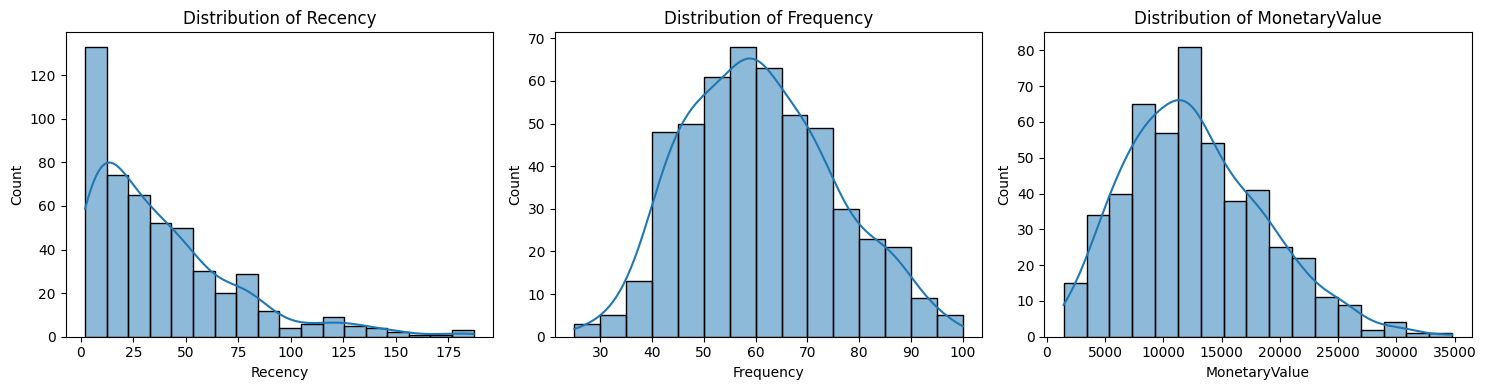

In [21]:
plt.figure(figsize=(15, 4))
for i, col in enumerate(['Recency', 'Frequency', 'MonetaryValue']):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Apply log transformation to reduce skewness

In [23]:
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].copy()
rfm_log = rfm_log + 1  # Avoid log(0)
rfm_log = np.log(rfm_log)

Scale the features using StandardScaler

In [24]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

Convert back to DataFrame

In [33]:
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

Save scaled data


In [26]:
rfm_scaled_df.to_csv("rfm_scaled.csv", index=False)

#Clustering

Determine the optimal number of clusters using Elbow Method and Silhouette Score

In [29]:
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K = range(2, 11)  # Try cluster sizes from 2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # Elbow method
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

Plot Elbow Method

Text(0.5, 1.0, 'Elbow Method')

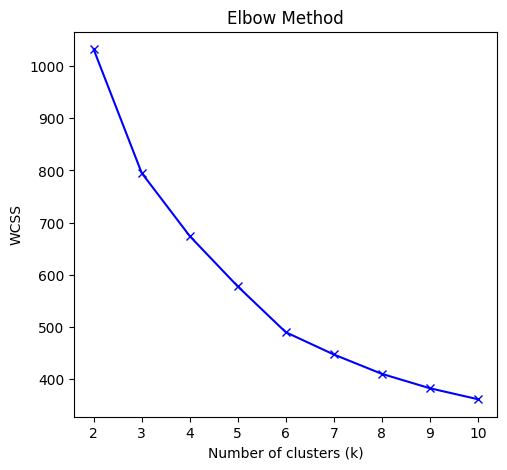

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')

Plot Silhouette Scores

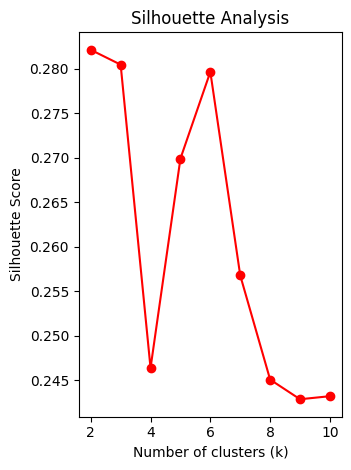

In [31]:
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

Apply KMeans Clustering with chosen number of clusters

In [35]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled)

Merge cluster labels back with original RFM data

In [37]:
rfm['Cluster'] = rfm_scaled['Cluster']

Save final data with cluster labels

In [38]:
rfm.to_csv("rfm_with_clusters.csv", index=False)

#Segment Profiling and Interpretation

Calculate average RFM values and customer count per cluster , assign custom segment names and map names to clusters

In [41]:
segment_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'}).reset_index()

segment_map = {
    0: 'Loyal High Spenders',
    1: 'At-Risk Low Spenders',
    2: 'New Customers',
    3: 'Churned',
    4: 'Potential Loyalists',
    5: 'Frequent Low Spenders',
    6: 'Recent High Spenders'
}

segment_profile['SegmentName'] = segment_profile['Cluster'].map(segment_map)

display(segment_profile)

,Cluster,Recency,Frequency,MonetaryValue,CustomerCount,SegmentName
0,0,63.000000,44.433735,9549.590000,83,Loyal High Spenders
1,1,54.471074,59.586777,15250.631901,121,At-Risk Low Spenders
2,2,37.625000,69.553571,7357.282321,56,New Customers
3,3,6.792683,52.682927,9781.304878,82,Churned
4,4,8.803030,75.469697,18788.668333,66,Potential Loyalists
5,5,38.571429,44.500000,3474.706071,28,Frequent Low Spenders
6,6,48.765625,78.890625,18590.475156,64,Recent High Spenders


Plot average RFM values per segment

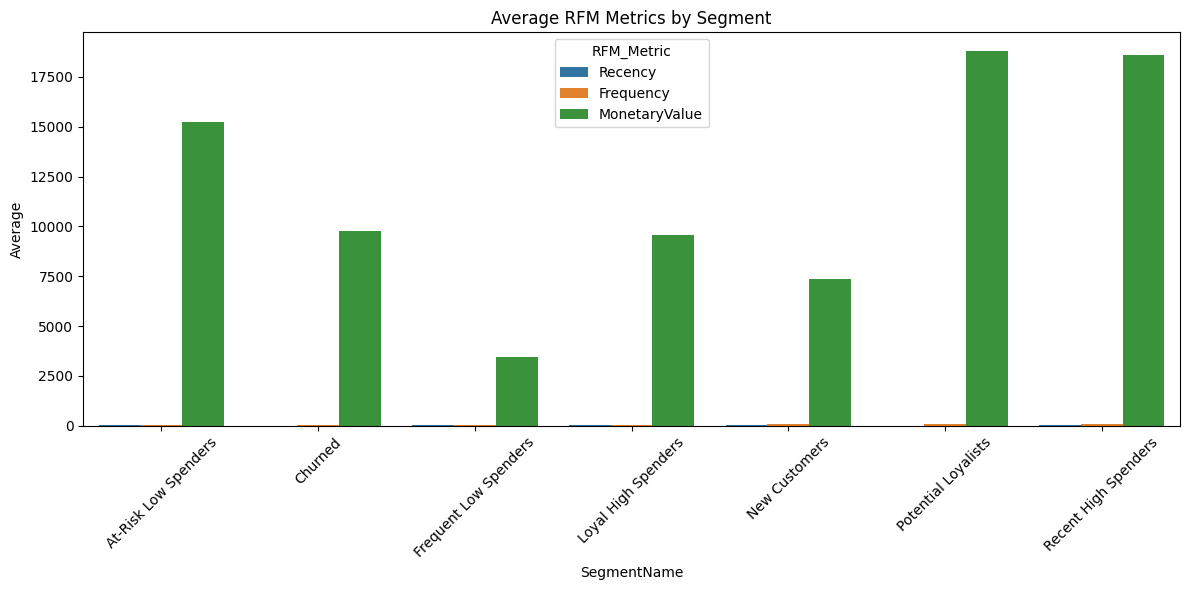

In [44]:
rfm_means = segment_profile.groupby('SegmentName')[['Recency', 'Frequency', 'MonetaryValue']].mean().reset_index()

rfm_means_melted = pd.melt(rfm_means, id_vars='SegmentName', var_name='RFM_Metric', value_name='Average')

plt.figure(figsize=(12, 6))
sns.barplot(data=rfm_means_melted, x='SegmentName', y='Average', hue='RFM_Metric')
plt.title('Average RFM Metrics by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Plot number of customers per segment

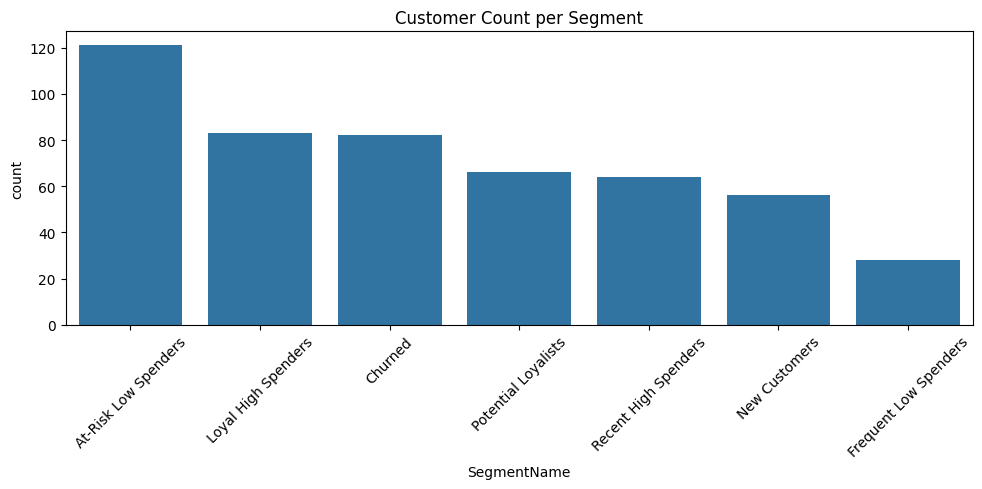

In [46]:
# Merge SegmentName from segment_profile to rfm
rfm = rfm.merge(segment_profile[['Cluster', 'SegmentName']], on='Cluster', how='left')

plt.figure(figsize=(10, 5))
sns.countplot(data=rfm, x='SegmentName', order=rfm['SegmentName'].value_counts().index)
plt.title('Customer Count per Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2D PCA plot to visualize clusters and scale and reduce to 2D

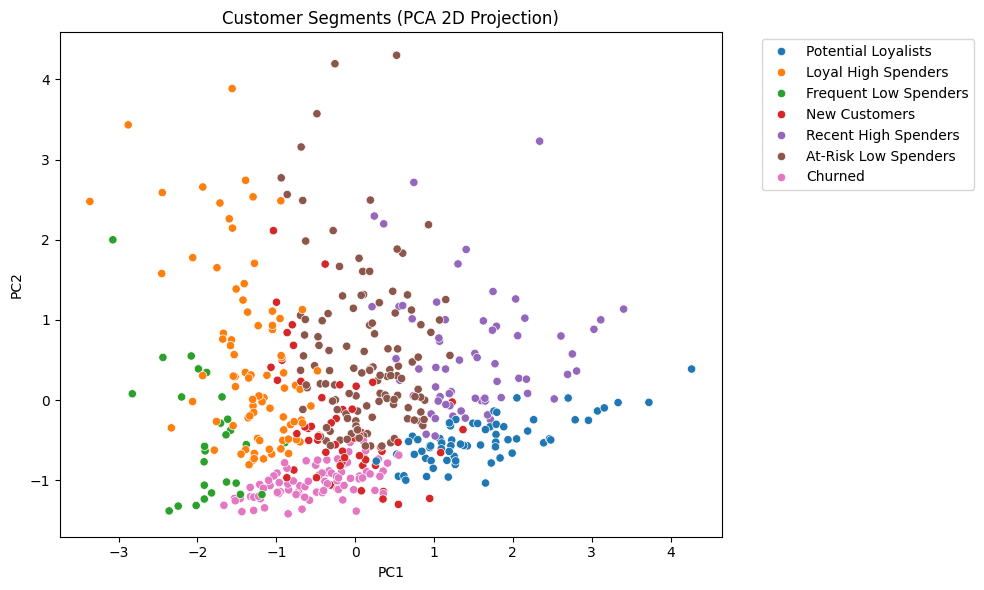

In [56]:
rfm_scaled = rfm[['Recency', 'Frequency', 'MonetaryValue']]
scaler = StandardScaler()
rfm_scaled_std = scaler.fit_transform(rfm_scaled)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_std)
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['SegmentName'] = rfm['SegmentName']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='SegmentName', palette='tab10')
plt.title('Customer Segments (PCA 2D Projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()